# KEN3450, Data Analysis 2020

Team name: Pinky and the Pope <br>
Team members: Hristo Minkov (i6161227 - Data Jesus) & Zhecho Mitev (i6170114) <br>
Date: 12.03.2020 <br>

**Kaggle Competition 2020**<br>

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

#import your classifiers here
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = None

c:\users\hmi\appdata\local\programs\python\python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\hmi\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\hmi\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.
c:\users\hmi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\hmi\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depre

# Diagnosing the Maastricht Flu 

You are given the early data for an outbreak of a dangerous virus originating from a group of primates being kept in a Maastricht biomedical research lab in the basement of Henri-Paul Spaaklaan building, this virus is dubbed the "Maastricht Flu".

You have the medical records of $n$ number of patients in `flu_train.csv`. There are two general types of patients in the data, flu patients and healthy (this is recorded in the column labeled `flu`, a 0 indicates the absences of the virus and a 1 indicates presence). Notice that the dataset is unbalanced and you can expect a similar imbalance in the testing set.

**Your task:** build a model to predict if a given patient has the flu. Your goal is to catch as many flu patients as possible without misdiagnosing too many healthy patients.

**The deliverable:** submit your final solution via Kaggle competition using the `flu_test.csv` data.

Maastricht Gemeente will use your model to diagnose sets of future patients (held by us). You can expect that there will be an increase in the number of flu patients in any groups of patients in the future.

Here are some benchmarks for comparison and for expectation management. Notice that because the dataset is unbalanced, we expect that there is going to be a large difference in the accuracy for each class, thus `accuracy` is a metric that might be misleading in this case (see also below). That's why the baselines below are based on the expected accuracy **per class** and also they give you an estimate for the AUROC on all patients in the testing data. This is the score you see in the Kaggle submission as well.

**Baseline Model:** 
- ~50% expected accuracy on healthy patients in training data
- ~50% expected accuracy on flu patients in training data
- ~50% expected accuracy on healthy patients in testing data (future data, no info on the labels)
- ~50% expected accuracy on flu patients in testing data (future data, no info on the labels)
- ~50% expected AUROC on all patients in testing data (future data, no info on the labels)

**Reasonable Model:** 
- ~70% expected accuracy on healthy patients in training data
- ~55% expected accuracy on flu patients, in training data
- ~70% expected accuracy on healthy patients in testing data (future data, no info on the labels, to be checked upon your submission)
- ~57% expected accuracy on flu patients, in testing data (future data, no info on the labels, to be checked upon your submission)
- ~65% expected AUROC on all patients, in testing data (future data, no info on the labels, to be checked from Kaggle)

**Grading:**
Your grade will be based on:
1. your model's ability to out-perform the benchmarks (they are kind of low, so we won't care much about this)
2. your ability to carefully and thoroughly follow the data analysis pipeline
3. the extend to which all choices are reasonable and defensible by methods you have learned in this class

## Step 1: Read the data, clean and explore the data

There are a large number of missing values in the data. Nearly all predictors have some degree of missingness. Not all missingness are alike: NaN in the `'pregnancy'` column is meaningful and informative, as patients with NaN's in the pregnancy column are males, where as NaN's in other predictors may appear randomly. 


**What do you do?:** We make no attempt to interpret the predictors and we make no attempt to model the missing values in the data in any meaningful way. We replace all missing values with 0.

However, it would be more complete to look at the data and allow the data to inform your decision on how to address missingness. For columns where NaN values are informative, you might want to treat NaN as a distinct value; You might want to drop predictors with too many missing values and impute the ones with few missing values using a model. There are many acceptable strategies here, as long as the appropriateness of the method in the context of the task and the data is discussed.

### Step 1.1 Load the data
Reading the train and the test set. Excluding all the rows that have NaN in the 'flu' column as this is the label that we want to predict.

In [2]:
#Train
df = pd.read_csv('data/flu_train.csv')
df = df[~np.isnan(df['flu'])]
df.head()

,ID,Gender,Age,Race1,Education,MaritalStatus,HHIncome,HHIncomeMid,Poverty,HomeRooms,HomeOwn,Work,Weight,Length,HeadCirc,Height,BMI,BMICatUnder20yrs,BMI_WHO,Pulse,BPSysAve,BPDiaAve,BPSys1,BPDia1,BPSys2,BPDia2,BPSys3,BPDia3,Testosterone,DirectChol,TotChol,UrineVol1,UrineFlow1,UrineVol2,UrineFlow2,Diabetes,DiabetesAge,HealthGen,DaysMentHlthBad,LittleInterest,Depressed,nPregnancies,nBabies,Age1stBaby,SleepHrsNight,SleepTrouble,PhysActive,PhysActiveDays,TVHrsDay,CompHrsDay,TVHrsDayChild,CompHrsDayChild,Alcohol12PlusYr,AlcoholDay,AlcoholYear,SmokeNow,Smoke100,Smoke100n,SmokeAge,Marijuana,AgeFirstMarij,RegularMarij,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow,flu
0,51624,male,34,White,High School,Married,25000-34999,30000.0,1.36,6.0,Own,NotWorking,87.4,NaN,NaN,164.7,32.22,NaN,30.0_plus,70.0,113.0,85.0,114.0,88.0,114.0,88.0,112.0,82.0,NaN,1.29,3.49,352.0,NaN,NaN,NaN,No,NaN,Good,15.0,Most,Several,NaN,NaN,NaN,4.0,Yes,No,NaN,NaN,NaN,NaN,NaN,Yes,NaN,0.0,No,Yes,Smoker,18.0,Yes,17.0,No,NaN,Yes,Yes,16.0,8.0,1.0,No,Heterosexual,NaN,0
1,51630,female,49,White,Some College,LivePartner,35000-44999,40000.0,1.91,5.0,Rent,NotWorking,86.7,NaN,NaN,168.4,30.57,NaN,30.0_plus,86.0,112.0,75.0,118.0,82.0,108.0,74.0,116.0,76.0,NaN,1.16,6.70,77.0,0.094,NaN,NaN,No,NaN,Good,10.0,Several,Several,2.0,2.0,27.0,8.0,Yes,No,NaN,NaN,NaN,NaN,NaN,Yes,2.0,20.0,Yes,Yes,Smoker,38.0,Yes,18.0,No,NaN,Yes,Yes,12.0,10.0,1.0,Yes,Heterosexual,NaN,0
2,51638,male,9,White,NaN,NaN,75000-99999,87500.0,1.84,6.0,Rent,NaN,29.8,NaN,NaN,133.1,16.82,NaN,12.0_18.5,82.0,86.0,47.0,84.0,50.0,84.0,50.0,88.0,44.0,NaN,1.34,4.86,123.0,1.538,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,51646,male,8,White,NaN,NaN,55000-64999,60000.0,2.33,7.0,Own,NaN,35.2,NaN,NaN,130.6,20.64,NaN,18.5_to_24.9,72.0,107.0,37.0,114.0,46.0,108.0,36.0,106.0,38.0,NaN,1.55,4.09,238.0,1.322,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,51647,female,45,White,College Grad,Married,75000-99999,87500.0,5.00,6.0,Own,Working,75.7,NaN,NaN,166.7,27.24,NaN,25.0_to_29.9,62.0,118.0,64.0,106.0,62.0,118.0,68.0,118.0,60.0,NaN,2.12,5.82,106.0,1.116,NaN,NaN,No,NaN,Vgood,3.0,None,None,1.0,NaN,NaN,8.0,No,Yes,5.0,NaN,NaN,NaN,NaN,Yes,3.0,52.0,NaN,No,Non-Smoker,NaN,Yes,13.0,No,NaN,No,Yes,13.0,20.0,0.0,Yes,Bisexual,NaN,0


In [3]:
#Test
df_test = pd.read_csv('data/flu_test.csv')

TEST_ID_VALUES = df_test['ID'].values

df_test.head()

,ID,Gender,Age,Race1,Education,MaritalStatus,HHIncome,HHIncomeMid,Poverty,HomeRooms,HomeOwn,Work,Weight,Length,HeadCirc,Height,BMI,BMICatUnder20yrs,BMI_WHO,Pulse,BPSysAve,BPDiaAve,BPSys1,BPDia1,BPSys2,BPDia2,BPSys3,BPDia3,Testosterone,DirectChol,TotChol,UrineVol1,UrineFlow1,UrineVol2,UrineFlow2,Diabetes,DiabetesAge,HealthGen,DaysMentHlthBad,LittleInterest,Depressed,nPregnancies,nBabies,Age1stBaby,SleepHrsNight,SleepTrouble,PhysActive,PhysActiveDays,TVHrsDay,CompHrsDay,TVHrsDayChild,CompHrsDayChild,Alcohol12PlusYr,AlcoholDay,AlcoholYear,SmokeNow,Smoke100,Smoke100n,SmokeAge,Marijuana,AgeFirstMarij,RegularMarij,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,SexOrientation,PregnantNow
0,51625,male,4,Other,NaN,NaN,20000-24999,22500.0,1.07,9.0,Own,NaN,17.0,NaN,NaN,105.4,15.30,NaN,12.0_18.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,51678,male,60,White,High School,Married,15000-19999,17500.0,1.03,5.0,Own,Working,74.6,NaN,NaN,169.9,25.84,NaN,25.0_to_29.9,84.0,152.0,100.0,154.0,98.0,150.0,98.0,154.0,102.0,NaN,1.34,6.39,238.0,NaN,NaN,NaN,No,NaN,Vgood,0.0,None,None,NaN,NaN,NaN,6.0,Yes,No,NaN,NaN,NaN,NaN,NaN,Yes,6.0,36.0,No,Yes,Smoker,16.0,NaN,NaN,NaN,NaN,No,Yes,20.0,1.0,NaN,No,NaN,NaN
2,51694,male,38,White,Some College,Married,20000-24999,22500.0,1.15,6.0,Own,Working,117.3,NaN,NaN,180.9,35.84,NaN,30.0_plus,60.0,147.0,81.0,160.0,84.0,150.0,80.0,144.0,82.0,NaN,0.93,4.68,73.0,0.468,NaN,NaN,No,NaN,Poor,4.0,Several,None,NaN,NaN,NaN,5.0,No,No,NaN,NaN,NaN,NaN,NaN,No,NaN,0.0,NaN,No,Non-Smoker,NaN,No,NaN,No,NaN,No,Yes,23.0,1.0,1.0,No,Heterosexual,NaN
3,51695,male,8,White,NaN,NaN,65000-74999,70000.0,3.55,5.0,Own,NaN,40.1,NaN,NaN,128.4,24.32,NaN,18.5_to_24.9,76.0,93.0,54.0,86.0,52.0,94.0,56.0,92.0,52.0,NaN,1.53,4.14,124.0,0.366,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51711,female,59,Other,8th Grade,Widowed,20000-24999,22500.0,1.37,4.0,Rent,NotWorking,54.3,NaN,NaN,145.1,25.79,NaN,25.0_to_29.9,84.0,150.0,0.0,144.0,0.0,150.0,0.0,150.0,0.0,NaN,1.06,4.16,42.0,0.389,NaN,NaN,Yes,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Non-Smoker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Step Simple data statistics
Showing the shape of the train and test data.

In [4]:
print('Train set shape: ', df.shape)
print('Test set shape: ', df_test.shape)

Train set shape:  (5246, 72)
Test set shape:  (1533, 71)


### Step 1.2 Removing columns
Removing columns based on irrelevance to the flu label or very high correlation to other columns. Still, we need to be extremely careful as some features contain hidden meaning to the 'flu' column. For example, we notice that the 'BMI' and the 'Weight' are highly correlated, however if we remove the first variable, the weight might not give enough information about whether the person is overweighted or not. Therefore both columns are included in the model.

In [5]:
remove_columns = ['ID', 'TVHrsDay', 'CompHrsDay', 'TVHrsDayChild', 'CompHrsDayChild', 'HeadCirc', 'HHIncomeMid']

df = df.drop(columns=remove_columns)
df_test = df_test.drop(columns=remove_columns)

### Step 1.3 Report on data missingness
Show the number of missing values for every column. We can see that the degree of missingness on the dataset is very high. The only variables without missing values are 'Gender', 'Age' and 'Race1'. However, we have discovered that several columns apply only for young people. For example, the 'Length' column apply only for children under 1 year old and there are no 'Height' values for those individuals. Thus we combine these column into one that represents the 'Height' of the person and the 'Length' column is removed. Same applies for 'BMICatUnder20yrs', 'UrineVol2', 'UrineFlow2' and other columns that have information only about the younger part of the population.

In [6]:
pd.set_option('display.max_rows', None)
print(df.isnull().sum())

Gender                 0
Age                    0
Race1                  0
Education           1672
MaritalStatus       1666
HHIncome             448
Poverty              403
HomeRooms             36
HomeOwn               33
Work                1357
Weight                40
Length              4890
Height               232
BMI                  236
BMICatUnder20yrs    4522
BMI_WHO              256
Pulse                870
BPSysAve             877
BPDiaAve             877
BPSys1              1033
BPDia1              1033
BPSys2               983
BPDia2               983
BPSys3               985
BPDia3               985
Testosterone        3238
DirectChol           909
TotChol              909
UrineVol1            609
UrineFlow1           946
UrineVol2           4483
UrineFlow2          4483
Diabetes             103
DiabetesAge         4916
HealthGen           1463
DaysMentHlthBad     1468
LittleInterest      1954
Depressed           1951
nPregnancies        3963
nBabies             4064


### Step 1.4 Removing columns with many missing values
Getting rid of more columns that either have missing values for most of the rows or we found out the irrelevance with the train data.

In [7]:
remove_columns = ['Length', 'SexOrientation', 'PregnantNow']

df = df.drop(columns=remove_columns)
df_test = df_test.drop(columns=remove_columns)

### Step 1.5 Filling missing values (categorical + numerical)
Defining a strategy for dealing with the missing values (NaNs) in the data. The general aim is to have no missing values after execution. It is also crucial to decide how to impute the data. For many columns it is a good idea to use the mean. For instance the poverty rate is a continuous value and if we use the average to replace the missing value then the model will not be affected. However, columns with discrete values like 'HomeOwn' or 'Work' have no mean value. Therefore, for some variables it is meaningful to introduce an 'UNK' token. Sometimes we also use a specific value to impute, for example most of the children do not have value for smoking, so we are assuming that they don't smoke, thus we replace the empty cells with a 'No' value.

It is good to note that the exact same strategy for removing is applied to the test set,.

In [8]:
nan_strategy = {
    'Education': 'UNK',
    'MaritalStatus': 'UNK',
    'HHIncome': 'UNK',
    'Poverty': df['Poverty'].mean(),
    'HomeRooms': df['HomeRooms'].mean(),
    'HomeOwn': 'UNK',
    'Work': 'UNK',
    'BMI': df['BMI'].mean(),
    'BMI_WHO': 'UNK',
    'Pulse': df['Pulse'].mean(),
    'BPSysAve': df['BPSysAve'].mean(),
    'BPDiaAve': df['BPDiaAve'].mean(),
    'BPSys1': df['BPSys1'].mean(),
    'BPDia1': df['BPDia1'].mean(),
    'BPSys2': df['BPSys2'].mean(),
    'BPDia2': df['BPDia2'].mean(),
    'BPSys3': df['BPSys3'].mean(),
    'BPDia3': df['BPDia3'].mean(),
    'DirectChol': df['DirectChol'].mean(),
    'TotChol': df['TotChol'].mean(),
    'UrineVol1': df['UrineVol1'].mean(),
    'UrineFlow1': df['UrineFlow1'].mean(),
    'Diabetes': 0,
    'HealthGen': 'Fair',
    'DaysMentHlthBad': 0,
    'LittleInterest': 'None',
    'Depressed': 'None',
    'SleepHrsNight': df['SleepHrsNight'].mean(),
    'SleepTrouble': 'No',
    'PhysActive': 'Yes',
    'PhysActiveDays': df['PhysActiveDays'].mean(),
    'Alcohol12PlusYr': 'No',
    'AlcoholYear': 0,
    'Smoke100': 'No',
    'Smoke100n': 'Non-Smoker',
    'Marijuana': 'No',
    'RegularMarij': 'No',
    'HardDrugs': 'No',
    'SexEver': 'No',
    'SexNumPartnLife': 0,
    'SexNumPartYear': 0,
    'SameSex': 'No',
    'Height': df['Height'].mean(),
    'Weight': df['Weight'].mean(),
    'UrineVol2': df['UrineVol2'].mean(),
    'UrineFlow2': df['UrineFlow2'].mean(),
    'DiabetesAge': df['DiabetesAge'].mean(),
    'nPregnancies': 0,
    'nBabies': 0,
    'Testosterone': df['Testosterone'].mean(),
    'SexAge': -1,
    'SmokeAge': -1,
    'SmokeNow': 'No',
    'AlcoholDay': 0,
    #'PregnantNow': 'No',
    #'SexOrientation': 'Heterosexual',
    'AgeRegMarij': -1,
    'BMICatUnder20yrs': 'UNK',
    'Age1stBaby': -1,
    'AgeFirstMarij': -1 
}

df.fillna(value=nan_strategy, inplace=True)
df_test.fillna(value=nan_strategy, inplace=True)

### Step 1.6 Merging/introducing features
Due to the data nature, there was no need to introduce any new column. Most of the features were correlated, so a better idea was to either remove one of them or use one of the columns to fill the missing data in the other. Therefore, this could be regarded as feature merging but it is performed in Step 1.5 above.

### Step 1.7 Label encoding for the categorical columns
Using a label encoder to encode all categorical columns. All the data from the train set is fitted and transformed, while the data from the test set is only transformed. At the end, all the data from the datasets is numerical and/or boolean.

In [9]:
le = preprocessing.LabelEncoder()

cat_columns = list(df.select_dtypes(exclude=["number", "bool_"]).columns)

for col in cat_columns:
    df[col] = le.fit_transform(df[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))

### Step 1.8 Normalizing columns
Checking the performance of the problem when some of the columns are normalized [0-1], so that the high variance of the column values do not affect the models.

In [10]:
columns_norm = df.drop(['flu'], axis=1).columns
columns_norm = []#['Testosterone', 'UrineVol1', 'SexNumPartnLife', 'AlcoholYear']

for col in columns_norm:
    max_value = df[col].max()
    min_value = df[col].min()
    
    df[col] = (df[col] - min_value) / (max_value - min_value)
    df_test[col] = (df_test[col] - min_value) / (max_value - min_value)

### Step 1.9 Data statistics
Show statistics for both the train and test sets. It is a good checkpoint for the features when considering their importance or characteristics. We get a sense of the medical measurements in the data - TotChol, UrineVol, UrineFlow, etc.

In [11]:
df.describe()

,Gender,Age,Race1,Education,MaritalStatus,HHIncome,Poverty,HomeRooms,HomeOwn,Work,Weight,Height,BMI,BMICatUnder20yrs,BMI_WHO,Pulse,BPSysAve,BPDiaAve,BPSys1,BPDia1,BPSys2,BPDia2,BPSys3,BPDia3,Testosterone,DirectChol,TotChol,UrineVol1,UrineFlow1,UrineVol2,UrineFlow2,Diabetes,DiabetesAge,HealthGen,DaysMentHlthBad,LittleInterest,Depressed,nPregnancies,nBabies,Age1stBaby,SleepHrsNight,SleepTrouble,PhysActive,PhysActiveDays,Alcohol12PlusYr,AlcoholDay,AlcoholYear,SmokeNow,Smoke100,Smoke100n,SmokeAge,Marijuana,AgeFirstMarij,RegularMarij,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex,flu
count,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.00000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000
mean,0.494281,35.078155,2.836066,3.324628,3.143538,7.399924,2.614229,6.147025,1.343500,2.084064,68.701921,160.341424,26.371601,2.670034,1.781929,73.546618,117.683680,66.554131,118.668882,67.511987,118.036125,66.70936,117.507627,66.311195,190.980538,1.357699,4.835764,117.415570,0.957834,119.213630,1.166626,1.056996,49.339394,1.922036,2.841975,1.068624,1.062524,0.748380,0.569958,3.205490,6.913895,0.178040,0.636866,3.747683,0.477316,1.356271,39.749142,0.136866,0.293366,0.293366,4.339497,0.253908,3.562714,0.119901,1.223599,0.089592,0.510103,8.403927,7.726458,0.621045,0.037934,0.059093
std,0.500015,23.032443,1.517047,1.540935,1.689925,3.597451,1.607039,2.216043,0.533888,0.908799,29.661102,20.572612,7.294276,0.896325,1.125027,11.169997,15.869876,13.563419,15.911811,12.665835,15.924934,13.44913,15.630011,14.069685,139.633804,0.352702,0.972441,84.806252,0.867329,34.406736,0.424505,0.305013,3.954170,1.281020,6.755346,0.376957,0.368826,1.571424,1.240700,9.216292,1.166521,0.382583,0.480949,1.244692,0.499533,2.803550,83.584535,0.343739,0.455348,0.455348,9.000374,0.435287,8.065566,0.324877,6.221043,0.285624,0.499946,9.605757,45.219179,1.824243,0.191054,0.235820
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.800000,83.600000,12.880000,0.000000,0.000000,40.000000,76.000000,0.000000,76.000000,0.000000,78.000000,0.00000,76.000000,0.000000,0.250000,0.390000,1.530000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,15.000000,2.000000,2.000000,2.000000,5.000000,1.160000,5.000000,1.000000,1.000000,53.200000,156.000000,21.470000,3.000000,1.000000,66.000000,108.000000,62.000000,108.000000,62.000000,108.000000,62.00000,108.000000,62.000000,190.980538,1.140000,4.220000,54.000000,0.448000,119.213630,1.166626,1.000000,49.339394,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,6.000000,0.000000,0.000000,3.747683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,33.000000,4.000000,4.000000,3.000000,7.000000,2.614229,6.000000,1.000000,2.000000,70.300000,164.300000,26.100000,3.000000,2.000000,73.546618,117.683680,66.554131,118.668882,67.511987,118.036125,66.70936,117.507627,66.311195,190.980538,1.357699,4.835764,107.000000,0.859000,119.213630,1.166626,

In [12]:
df_test.describe()

,Gender,Age,Race1,Education,MaritalStatus,HHIncome,Poverty,HomeRooms,HomeOwn,Work,Weight,Height,BMI,BMICatUnder20yrs,BMI_WHO,Pulse,BPSysAve,BPDiaAve,BPSys1,BPDia1,BPSys2,BPDia2,BPSys3,BPDia3,Testosterone,DirectChol,TotChol,UrineVol1,UrineFlow1,UrineVol2,UrineFlow2,Diabetes,DiabetesAge,HealthGen,DaysMentHlthBad,LittleInterest,Depressed,nPregnancies,nBabies,Age1stBaby,SleepHrsNight,SleepTrouble,PhysActive,PhysActiveDays,Alcohol12PlusYr,AlcoholDay,AlcoholYear,SmokeNow,Smoke100,Smoke100n,SmokeAge,Marijuana,AgeFirstMarij,RegularMarij,AgeRegMarij,HardDrugs,SexEver,SexAge,SexNumPartnLife,SexNumPartYear,SameSex
count,1533.000000,1533.00000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000,1533.000000
mean,0.499674,36.72668,2.818656,3.272016,3.070450,7.264840,2.584825,6.111392,1.350946,2.004566,70.290038,160.384432,26.861891,2.705806,1.833007,73.957913,118.784577,67.161170,119.721705,67.824086,119.122411,67.250660,118.424494,67.093152,189.683905,1.357129,4.846562,117.770146,0.953903,117.843718,1.144488,1.082844,49.358244,1.926941,3.445532,1.055447,1.041096,0.899543,0.657534,3.599478,6.908375,0.195695,0.629485,3.731622,0.479452,1.273973,39.008480,0.160470,0.337247,0.337247,4.955643,0.257665,3.673190,0.129159,1.465753,0.103718,0.510111,8.291585,8.046314,0.568819,0.038487
std,0.500163,23.36989,1.527722,1.577330,1.718884,3.687046,1.622222,2.276603,0.547479,0.923641,30.246189,20.963589,7.633254,0.860475,1.123930,11.223638,16.615357,13.519999,16.250698,12.536332,16.591882,13.644847,16.180995,13.501877,133.541808,0.358456,0.980195,83.565359,0.809327,33.603157,0.351531,0.325663,4.236884,1.260936,7.496766,0.418476,0.384432,1.902062,1.323420,9.492063,1.266130,0.396864,0.483100,1.275503,0.499741,2.232698,83.539272,0.367161,0.472924,0.472924,9.070186,0.437491,8.216683,0.335485,6.727125,0.304994,0.500061,9.540783,33.731253,1.851890,0.192431
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.500000,84.900000,12.900000,0.000000,0.000000,40.000000,78.000000,0.000000,72.000000,0.000000,76.000000,0.000000,80.000000,0.000000,0.650000,0.470000,2.280000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,0.000000,16.00000,2.000000,2.000000,2.000000,4.000000,1.100000,4.000000,1.000000,1.000000,56.200000,156.100000,21.700000,3.000000,1.000000,68.000000,108.000000,62.000000,110.000000,64.000000,110.000000,62.000000,108.000000,62.000000,190.980538,1.140000,4.220000,55.000000,0.452000,119.213630,1.166626,1.000000,49.339394,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,6.000000,0.000000,0.000000,3.747683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
50%,0.000000,36.00000,4.000000,4.000000,2.000000,7.000000,2.570000,6.000000,1.000000,2.000000,72.400000,164.500000,26.371601,3.000000,2.000000,73.546618,117.683680,66.554131,118.668882,67.511987,118.036125,66.709360,117.507627,66.311195,190.980538,1.357699,4.835764,106.000000,0.877000,119.213630,1.166626,1.000000,49.339394,2.000000,0.000000,1.000000,1.0000

### Step 1.10 Observe class distribution
Calculating the distribution (and percentage) of the positive and negative classes.

In [13]:
print(df['flu'].value_counts())

print('\nPositive class: ', round(df['flu'].value_counts()[1] / df.shape[0], 2), '%')
print('Negative class: ', round(df['flu'].value_counts()[0] / df.shape[0], 2), '%')

0    4936
1     310
Name: flu, dtype: int64

Positive class:  0.06 %
Negative class:  0.94 %


We can observe that the data is extremely imbalanced since only 6 per cent of the population has the flu, therefore it would be difficult to predict the positive cases. For this reason we can try to use some models that can handle imbalnced data such as "Balanced Logistic Regression" and "Balanced Random Forest".

### Step 1.11 Plotting a correlation matrix
Plotting the correlation matrix for the entire train dataset. It reveals several logical clusters of positively and negatively correlated features. For example, all the biomedical data is clustered on the heatmap as it is considerably correlated. Similarly, there is negative correlation between the gender feature and the pregranacy data as probably only mothers answered this question in the questionnaire.

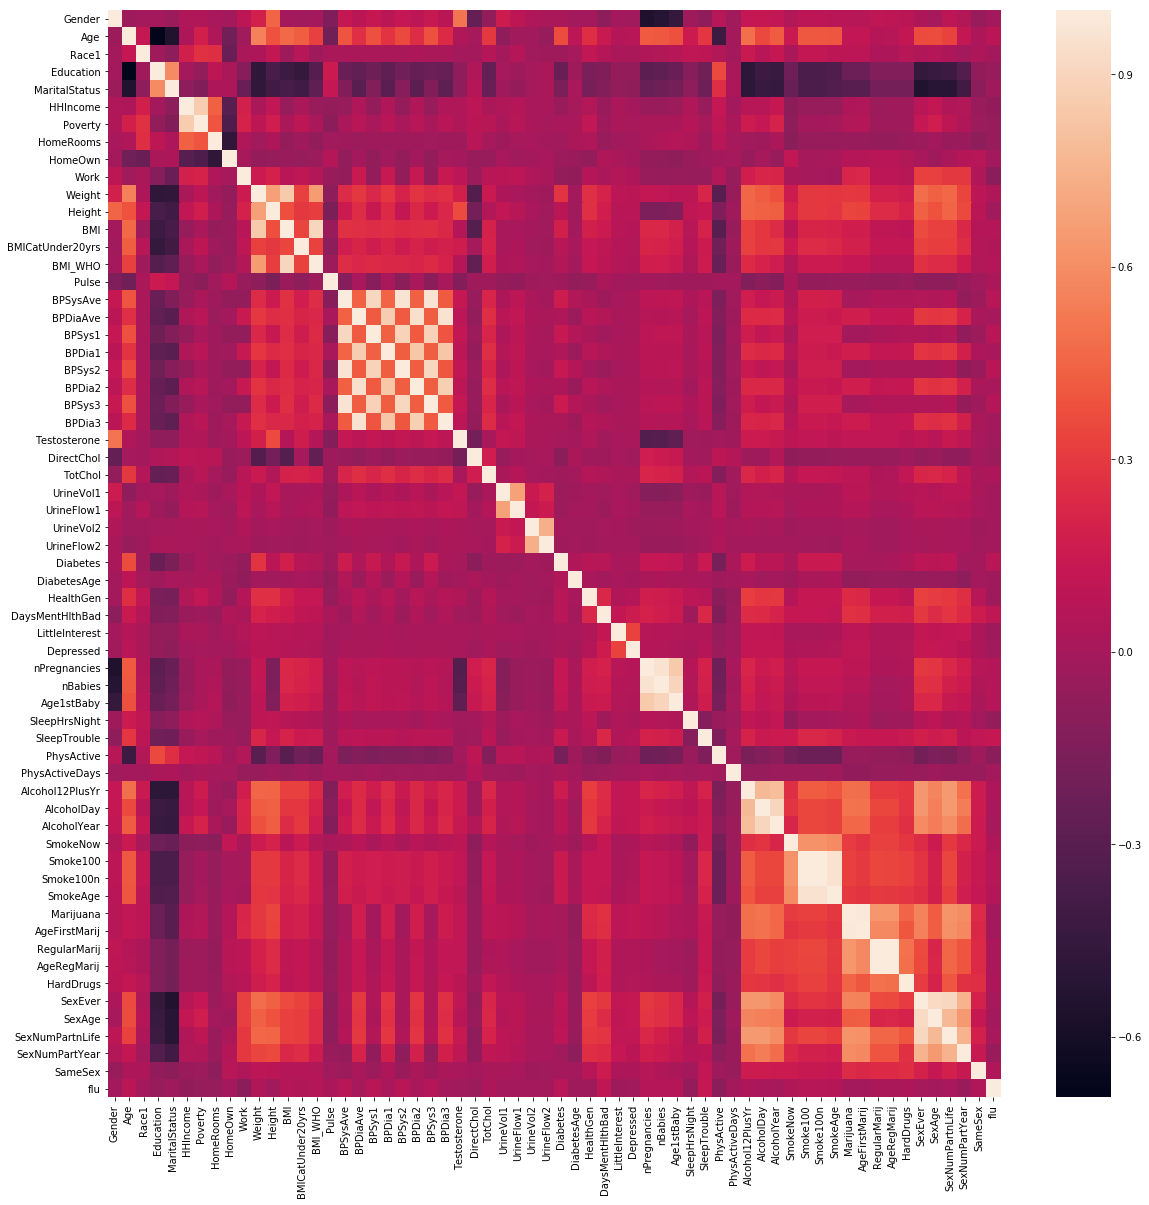

In [14]:
corr = df.corr(method="spearman")

plt.figure(figsize=(20, 20))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### Step 1.12 Stratified train/validation split
We perform stratified train/validation set on the original train set as we do not have the true labels for the test set. The validation set will be used to test, score and compare our models with the set benchmarks on the problem. The performed split is 85% to 15% and the train/validation sets shapes are also reported at the end.

In [15]:
y = df['flu'].values
df = df.drop(['flu'], axis=1)
X = df.values

#y_test = df_test['flu'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.15, stratify=y, random_state=42)

print('Train set shape: ', X_train.shape)
print('Validation set shape: ', X_valid.shape)

Train set shape:  (4459, 61)
Validation set shape:  (787, 61)


## Step 2: On evaluation

### AUROC

As mentioned abbove, we will use the accuracy scores for each class and for the whole dataset, as well as the AUROC score from Kaggle platform. You can coimpute AUROC locally (e.g. on your train/validation set) by calling the relevant scikit learn function:

In [16]:
###AUROC locally - NOT USED HERE (LEFT FOR MARKING PURPOSES)

#score = roc_auc_score(real_labels, predicted_labels)

### Accuracy (per class)

Below there is a function that will be handy for your models. It computes the accuracy per-class, based on a model you pass as parameter and a dataset (split to x/y)

In [17]:
def extended_score(model, x_test, y_test):
    overall = 0
    class_0 = 0
    class_1 = 0
    for i in range(100):
        sample = np.random.choice(len(x_test), len(x_test))
        x_sub_test = x_test[sample]
        y_sub_test = y_test[sample]
        
        overall += model.score(x_sub_test, y_sub_test)
        class_0 += model.score(x_sub_test[y_sub_test==0], y_sub_test[y_sub_test==0])
        class_1 += model.score(x_sub_test[y_sub_test==1], y_sub_test[y_sub_test==1])

    return pd.Series([overall / 100., 
                      class_0 / 100.,
                      class_1 / 100.],
                      index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

In [18]:
#same job as before, but faster?

score = lambda model, x_val, y_val: pd.Series([model.score(x_val, y_val), 
                                                 model.score(x_val[y_val==0], y_val[y_val==0]),
                                                 model.score(x_val[y_val==1], y_val[y_val==1])], 
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

## Step 3: Model Choice

The first task is to decide which classifier to use (from the ones that we learned this block), i.e. which one would best suit our task and our data. Note that our data are heavily unbalanced, thus you need to do some exploration on how different classifiers handle inbalances in the data (we will discuss some of these techniques during week 3 lecture).

It would be possible to do brute force model comparison here - i.e. tune all models and compare which does best with respect to various benchmarks. However, it is also reasonable to do a first round of model comparison by running models (with out of the box parameter settings) on the training data and eliminating some models which performed very poorly.

Let the best model win!

### Step 3.1 Models definition
We define 7 models that should aim to tackle the baseline and reasonable scores. The first model is the Vanilla Logistic Model which is the only simple model in the sense that others have specific characteristics to deal with imbalanced data. Most of the models have a parameter class_weight which is set to 'balanced' to transform the plain model to a balanced (binary) classifier - Balanced Logistic Regression and Support Vector Machine. Four of the models come from a specific Python library imblearn that deals with imbalanced data. They have the balancing feature already built-in without implicit invocation. For clarity, the sampling_strategy parameter is set to 'auto' (the default value) for all imblearn ensamble classifiers - Balanced Random Forest, Easy Ensamble and Random Undersampling Ada Boost. The last model is the XGBoost classifier which is based on the Gradient Boosting framework. Hyperparameter Grid search is performed on the XGBoost classifier in order to obtain the best performing parameter values.

In [19]:
### fancy models that solve the problem

MODELS = [
    ('Normal Logistic Regression', LogisticRegression(C=.01, random_state=42, max_iter=100000)),
    ('Balanced Logistic Regression', LogisticRegression(C=.01, random_state=42, class_weight='balanced', max_iter=100000, penalty='l2', solver='liblinear')),
    ('Balanced Random Forest', BalancedRandomForestClassifier(sampling_strategy='auto', max_depth=4, random_state=42)),
    ('Balanced Bagging', BalancedBaggingClassifier(random_state=42, sampling_strategy='auto')),
    ('Easy Ensamble', EasyEnsembleClassifier(random_state=42, sampling_strategy='auto')),
    ('Random Undersampling Ada Boost', RUSBoostClassifier(random_state=42, sampling_strategy='auto')),
    ('Support Vector Machine', SVC(C=.01, class_weight='balanced', kernel='linear', random_state=42)),
    ('XGBoost', xgb.XGBClassifier(random_state=42, learning_rate=0.007, n_estimators=893, scale_pos_weight=16,
                                    max_depth=3, min_child_weight=4, gamma=0.23, subsample=0.55, colsample_bytree=0.30,
                                    reg_alpha=0.000, objective='binary:logistic', nthread=4, importance_type='total_gain'))
]

### Step 3.2 Training and scoring the models
Scoring the models based on the 'score' function provided in the starter notebook. It reports on the accuracy on both the positive and the negative classes. This allows us to compare the performance of the models on the validation sets and see how the results compare to the benchmarks defined in the assignment description. All the results are saved in a dataframe and further displayed. We can see that the Normal Logistic Regression predicts mostly the negative class and thus has accuracy on it 1.00 whereas it performs extremely poor on the positive class. On the other hand, the balanced models perform sufficiently good - each of the other six models outperform the baseline and reasonable benchmarks on the validation sets (we are not able to test the results on the real test set as we do not have the true labels). 

In [20]:
scores_dict = dict()

for model in MODELS:
    print('Training a ', model[0], '...')
    model[1].fit(X, y)
    model_score = score(model[1], X_valid, y_valid)
    
    scores_dict[model[0]] = model_score
    
scores_df = pd.DataFrame(scores_dict)
scores_df

Training a  Normal Logistic Regression ...
Training a  Balanced Logistic Regression ...
Training a  Balanced Random Forest ...
Training a  Balanced Bagging ...
Training a  Easy Ensamble ...
Training a  Random Undersampling Ada Boost ...
Training a  Support Vector Machine ...
Training a  XGBoost ...


,Normal Logistic Regression,Balanced Logistic Regression,Balanced Random Forest,Balanced Bagging,Easy Ensamble,Random Undersampling Ada Boost,Support Vector Machine,XGBoost
overall accuracy,0.941550,0.743329,0.770013,0.889454,0.673443,0.739517,0.745870,0.853875
accuracy on class 0,1.000000,0.744595,0.775676,0.883784,0.662162,0.729730,0.747297,0.858108
accuracy on class 1,0.021277,0.723404,0.680851,0.978723,0.851064,0.893617,0.723404,0.787234


### Feature importances
The tree-based solutions - Balanced Random Forest and XGBoost classifiers allow for examining the importance level for all features. We observe that the five most important features for the XGBoost model are: HealthGen, DaysMentHlthBad, Age, UrineFlow1 and BMI. The top features for the Balanced Random Forest are: DaysMentHlthBad, HealthGen, Age, SleepTrouble and BMI. Overall, both rankings are very similar and give us a good estimate for which features to exclude if we want to lower their number and to which parameters the model is highly sensitive to. Therefore, small changes in the most important features (like different NaN handling, normalization, etc.) would have greater effect on the model performance.

In [21]:
importances_brf = MODELS[2][1].feature_importances_
importances_xgb = MODELS[7][1].get_booster().get_score(importance_type="total_gain")

importances_xgb = list(map(lambda x: round(x[1], 2), sorted(importances_xgb.items(), key=lambda x: int(x[0].split('f')[1]))))

df_imp = pd.DataFrame(data={'Feature': df.columns, 'Importance BRF': importances_brf, 'Importance XGB': importances_xgb})
df_imp = df_imp.sort_values(by=['Importance BRF'], ascending=False)

df_imp

,Feature,Importance BRF,Importance XGB
34,DaysMentHlthBad,0.088063,24892.10
33,HealthGen,0.078645,39414.33
1,Age,0.063783,24039.99
41,SleepTrouble,0.043734,6652.63
12,BMI,0.039281,10487.09
42,PhysActive,0.037884,5477.26
35,LittleInterest,0.037295,8040.92
9,Work,0.031087,5688.63
5,HHIncome,0.026429,5084.49
10,Weight,0.026284,6911.89


## Solution extraction for Kaggle

Predicting whether the people from the test set have the flu or not. Every models tries to predict all the labels and the results are saved in the 'outputs' folder into separate .csv files ready for submission. The value counts for every output are displayed.

In [22]:
for model in MODELS:
    print('Saving the outputs for ', model[0], ' ...')
    model_predictions = model[1].predict(df_test[df.columns].values)
    
    df_output = pd.DataFrame(data={'ID': TEST_ID_VALUES, 'Prediction': model_predictions})
    print(df_output['Prediction'].value_counts(), '\n')
    
    df_output.to_csv('outputs/' + model[0] + ' output.csv', index=False)

Saving the outputs for  Normal Logistic Regression  ...
0    1523
1      10
Name: Prediction, dtype: int64 

Saving the outputs for  Balanced Logistic Regression  ...
0    1008
1     525
Name: Prediction, dtype: int64 

Saving the outputs for  Balanced Random Forest  ...
0    1039
1     494
Name: Prediction, dtype: int64 

Saving the outputs for  Balanced Bagging  ...
0    1205
1     328
Name: Prediction, dtype: int64 

Saving the outputs for  Easy Ensamble  ...
0    901
1    632
Name: Prediction, dtype: int64 

Saving the outputs for  Random Undersampling Ada Boost  ...
0    984
1    549
Name: Prediction, dtype: int64 

Saving the outputs for  Support Vector Machine  ...
0    1026
1     507
Name: Prediction, dtype: int64 

Saving the outputs for  XGBoost  ...
0    1177
1     356
Name: Prediction, dtype: int64 



## Step 3: Conclusions

Highlight at the end of your notebook, which were the top-3 approaches that produced the best scores for you. That is, provide a table with the scores you got (on the AUROC score you get from Kaggle) and make sure that you judge these in relation to your work on the training set.

### Step 3.1 Scores table
The scores table provide the results for every model based on the accuracy on both classes and the AUROC evaluation from Kaggle. 

In [23]:
scores_df = scores_df.append(
    pd.Series([0.51041, 0.66105, 0.66330, 0.61285, 0.65483, 0.65544, 0.65595, 0.69036],
              name='AUROC score', index=scores_df.columns), ignore_index=False)

scores_df

,Normal Logistic Regression,Balanced Logistic Regression,Balanced Random Forest,Balanced Bagging,Easy Ensamble,Random Undersampling Ada Boost,Support Vector Machine,XGBoost
overall accuracy,0.941550,0.743329,0.770013,0.889454,0.673443,0.739517,0.745870,0.853875
accuracy on class 0,1.000000,0.744595,0.775676,0.883784,0.662162,0.729730,0.747297,0.858108
accuracy on class 1,0.021277,0.723404,0.680851,0.978723,0.851064,0.893617,0.723404,0.787234
AUROC score,0.510410,0.661050,0.663300,0.612850,0.654830,0.655440,0.655950,0.690360


### Step 3.2 Discussion
As we can observe, the models are performing on the Kaggle AUROC score with the following ranking:
1. XGBoost
2. Balanced Random Forest
3. Balanced Logistic Regression
4. Support Vector Machine
5. Random Undersampling Ada Boost
6. Easy Ensamble
7. Balanced Bagging
8. Normal Logistic Regression

The fact that the two best performing models are originally based on trees and/or forest structures is important as this allows for model interpretability. Therefore, we were able to construct a dataframe that shows the importance (in terms of total gain) for all data features.

The only model that is not able to reach the baseline benchmark is the Normal Logistic Regression model as it mainly predicts the negative class - less accuracy on the flu patients. Similarly, it would not be able to reach the reasonable benchmark results.

All other models outperform the baseline benchmark. However, the Easy Ensamble binary classifier is not able to reach the desired accuracy on the healthy patients for the reasonable benchmark. Therefore, it would not be considered a reasonable model. Moreover, the Balanced Bagging classifier underperforms on the AUROC score from Kaggle. The desired score is approximately .65 but the model reaches .612850 which is not enough.

Finally, the models that are able to reach both the baseline and reasonable benchmarks are:
1. XGBoost
2. Balanced Random Forest
3. Balanced Logistic Regression
4. Support Vector Machine
5. Random Undersampling Ada Boost

Still, if our aim is to deploy the model to production, we would choose the models that score most and are also as interpretable as possible:
1. XGBoost
2. Balanced Random Forest
3. Random Undersampling Ada Boost